In [26]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt

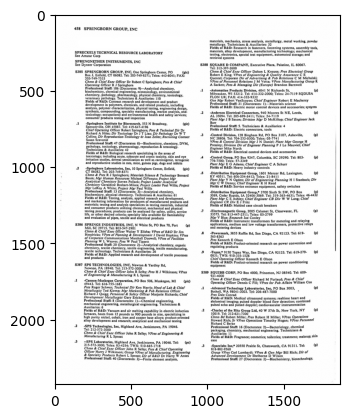

In [75]:
image_path = "/home/midge/Downloads/1987-page468.tiff"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(image, cmap="gray")
plt.show()

In [78]:
height, width = image.shape
middle = (width // 2) - 40

left_col = image[:, 45:middle]
# right_col = image[:, middle:30]

cv2.imwrite("/home/midge/Downloads/left_half.tiff", left_col)
# cv2.imwrite("/home/midge/Downloads/right_half.tiff", right_col)

True

In [29]:
left = cv2.imread("/home/midge/Downloads/left_half.tiff", cv2.IMREAD_GRAYSCALE)
right = cv2.imread("/home/midge/Downloads/right_half.tiff", cv2.IMREAD_GRAYSCALE)

In [44]:
def get_entry_boxes(img):
    d = pytesseract.image_to_string(img, output_type=pytesseract.Output.DICT)

    entry_boxes = []
    for i in range(len(d['text'])):
        if d['text'][i].strip():
            print(d)
            x, y, w, h = d['left'][i], d['top'][i], d['width'][i], d['height'][i]
            if y > 10:
                entry_boxes.append((x, y, w, h))

    return entry_boxes

In [39]:
def draw_boxes(img):
    entry_boxes = get_entry_boxes(img)
    entry_boxes = sorted(entry_boxes, key=lambda x: x[1])

    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert to color for drawing
    last_y = None

    for i, (x, y, w, h) in enumerate(entry_boxes):
        if last_y is not None:
            cv2.rectangle(img_color, (0, last_y), (img.shape[1], y), (0, 255, 0), 2)
        last_y = y

    return img_color

In [40]:
def show_image(img, title="Image"):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis("off")
    plt.show()

In [45]:
left_boxes = draw_boxes(left)

{'text': '458 SPRINGBORN GROUP, INC\n\nSPRECKELS TECHNICAL RESOURCE LABORATORY\nSce Amstar Corp\n\nSPRENGNETHER INSTRUMENTS, INC\nSce Dyneer Corporation\n\nS385\n\n1\n\nS386\n\nS387\n\n1\n\n3\n\nSPRINGBORN GROUP, INC, One Springborn Center, PO (gic)\nBox J, Enficld, CT 06082. Tel: 203-749-8371; Telex: 443-6041; FAX:\n203-749-7533\n\nChmn & Chief Exec Officer Dr Robert C Springborn; Pres & Chief\nOperating Officer R J Springborn\n\nProfessional Staff: 106 (Doctorates: 9)—Analytical chemistry,\nbiochemistry, chemical engineering, ecotoxicology, environmental\nchemistry, pathology, pharmacology, physical chemistry, toxicology,\nveterinary pathology. Technicians & Auxiliaries: 110\n\nFields of R&D: Contract rescarch and development and product\ndevelopment in polymers, chemicals, and related products, including\nanalysis, polymer characterization, physical testing, engincering design,\nsynthesis, compounding, specialty manufacturing, market analysis, and-\ntoxicology; occupational and envi

KeyError: 'left'

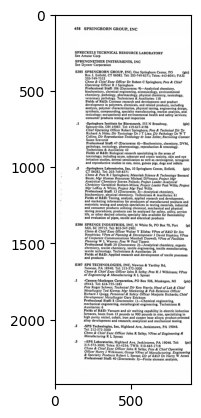

In [14]:
plt.imshow(left, cmap="gray")
plt.show()

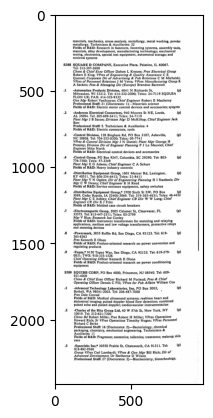

In [15]:
plt.imshow(right, cmap="gray")
plt.show()

In [16]:
left = cv2.GaussianBlur(left, (5, 5), 0)
right = cv2.GaussianBlur(right, (5, 5), 0)

In [19]:
left_hist = cv2.calcHist([left], [0], None, [256], [0, 256])
left_hist_norm = left_hist.ravel() / left_hist.sum()
left_Q = left_hist_norm.cumsum()

bins = np.arange(256)

fn_min = np.inf
thresh = -1

for i in range(1,256):
    p1, p2 = np.hsplit(left_hist_norm, [i]) # probabilities
    q1, q2 = left_Q[i], left_Q[255] - left_Q[i] # cum sum of classes
    if q1 < 1.e-6 or q2 < 1.e-6:
        continue
    b1, b2 = np.hsplit(bins, [i]) # weights

    # finding means and variances
    m1, m2 = np.sum(p1 * b1) / q1, np.sum(p2 * b2) / q2
    v1, v2 = np.sum(((b1 - m1) ** 2) * p1) / q1, np.sum(((b2 - m2) ** 2) * p2) / q2

    # calculates the minimization function
    fn = v1 * q1 + v2 * q2
    if fn < fn_min:
        fn_min = fn
        thresh = i

# find otsu's threshold value with OpenCV function
left_ret, left_otsu = cv2.threshold(left, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

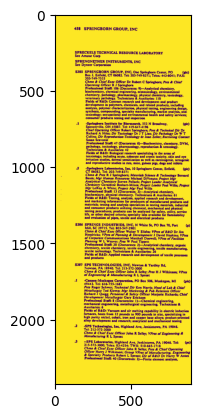

In [21]:
plt.imshow(left_otsu)
plt.show()

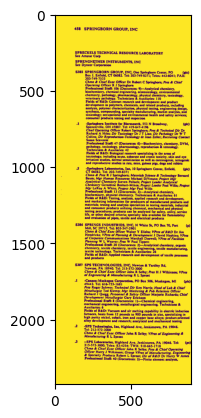

In [22]:
kernel = np.ones((2,2), np.uint8)
processed = cv2.morphologyEx(left_otsu, cv2.MORPH_CLOSE, kernel)

plt.imshow(processed)
plt.show()

In [25]:
cv2.imwrite("/home/midge/Downloads/left_half_processed.tiff", processed)

True

In [79]:
img = cv2.imread("/home/midge/Downloads/left_half.tiff")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [80]:
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

In [81]:
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
dilation = cv2.dilate(thresh, rect_kernel, iterations=1)

cv2.imwrite("/home/midge/Downloads/left_dilation.tiff", dilation)

True

In [82]:
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

In [83]:
img2 = img.copy()

cv2.drawContours(img2, contours, -1, (0, 255, 0), 3)

cv2.imwrite("/home/midge/Downloads/left_half_contours.tiff", img2)

True

In [58]:
img3 = img.copy()

file = open("/home/midge/Downloads/recognized.txt", "w+")
file.write("")
file.close()

In [59]:
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    rect = cv2.rectangle(img3, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cropped = img3[y:y + h, x:x + w]
    file = open("/home/midge/Downloads/recognized.txt", "w+")
    text = pytesseract.image_to_string(cropped)
    file.write(text)
    file.write("\n")
    file.close()

In [85]:
image_bb = cv2.imread("/home/midge/Downloads/left_half_contours.tiff")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

text = pytesseract.image_to_string(thresh, config="--psm 6")
print(text)

458 SPRINGBORN GROUP, INC
SPRECKELS TECHNICAL RESOURCE LABORATORY
Sce Amstar Corp
SPRENGNETHER INSTRUMENTS, INC
Sce Dyneer Corporation
5385 SPRINGBORN GROUP, INC, One Springbom Center, PO (gic)
Box J, Enficld, CT 06082, Tel: 203-749-8371; Telex: 443-6041; FAX:
203-749-7533
Chmn & Chief Exec Officer Dr Robert C Springborn; Pres & Chief
Operating Officer R ] Springborn
Professional Staff: 106 (Doctorates: 9)—Analytical chemistry,
biochemistry, chemical engineering, ecotoxicology, environmental
chemistry, pathology, pharmacology, physical chemistry, toxicology,
veterinary pathology. Technicians & Auxiliaries: 110
Fields of R&D: Contract rescarch and development and product
development in polymers, chemicals, and related products, including
analysis, polymer characterization, physical testing, engincering design,
synthesis, compounding, specialty manufacturing, market anslysis, and-
toxicology: occupational and environmental health and safety services;
consumer products testing and inspect

In [86]:
cv2.imwrite("/home/midge/Downloads/left_half_thresh.tiff", thresh)

True